In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

# import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D
from tensorflow.keras.preprocessing import image



print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.8.0


In [2]:
# Unzip the dataset from drive
!unzip drive/My\ Drive/IP/Cretu_Alzhimer.zip
# !unzip drive/My\ Drive/IP/train_cretu.zip

Archive:  drive/My Drive/IP/Cretu_Alzhimer.zip
   creating: Cretu_Alzhimer/test/
   creating: Cretu_Alzhimer/test/AD_Dementia/
  inflating: Cretu_Alzhimer/test/AD_Dementia/500.png  
  inflating: Cretu_Alzhimer/test/AD_Dementia/501.png  
  inflating: Cretu_Alzhimer/test/AD_Dementia/502.png  
  inflating: Cretu_Alzhimer/test/AD_Dementia/503.png  
  inflating: Cretu_Alzhimer/test/AD_Dementia/504.png  
  inflating: Cretu_Alzhimer/test/AD_Dementia/505.png  
  inflating: Cretu_Alzhimer/test/AD_Dementia/506.png  
  inflating: Cretu_Alzhimer/test/AD_Dementia/507.png  
  inflating: Cretu_Alzhimer/test/AD_Dementia/508.png  
  inflating: Cretu_Alzhimer/test/AD_Dementia/509.png  
  inflating: Cretu_Alzhimer/test/AD_Dementia/510.png  
  inflating: Cretu_Alzhimer/test/AD_Dementia/511.png  
  inflating: Cretu_Alzhimer/test/AD_Dementia/512.png  
  inflating: Cretu_Alzhimer/test/AD_Dementia/513.png  
  inflating: Cretu_Alzhimer/test/AD_Dementia/514.png  
  inflating: Cretu_Alzhimer/test/AD_Dementia/515

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_SIZE = 176
IMAGE_SIZE = [176, 208]
DIM = (IMG_SIZE, IMG_SIZE)
BATCH_SIZE = 16

In [4]:
# base_dir = "/content/Alzheimer_s Dataset/"
# base_dir = "/content/Alzheimer_s Dataset_Full/"
# base_dir = "/content/"
base_dir = "/content/Cretu_Alzhimer/"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
# work_dir = root_dir + "dataset/"

# if os.path.exists(work_dir):
#     remove_tree(work_dir)
    

# os.mkdir(work_dir)
# copy_tree(train_dir, work_dir)
# # copy_tree(test_dir, work_dir)
# print("Working Directory Contents:", os.listdir(work_dir)

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.1,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.1,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 426 files belonging to 2 classes.
Using 384 files for training.
Found 426 files belonging to 2 classes.
Using 42 files for validation.


In [6]:
class_names = ['Dementia', 'NonDementia']
# class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)

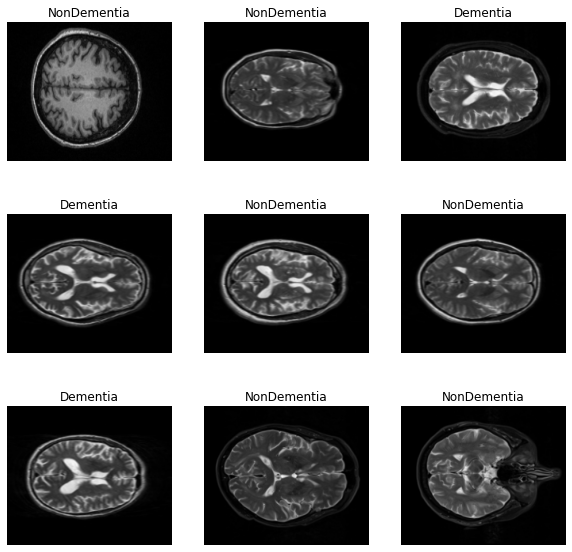

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [8]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [9]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
np.random.seed(1000)

In [11]:
# cross validation
# inbunatatirea meta parametrii

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    METRICS = [tf.keras.metrics.AUC(name='auc')]
    
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )
    
    return model

In [ ]:


# # AlexNet model
# class AlexNet(Sequential):
#     def __init__(self, input_shape, num_classes):
#         super().__init__()

#         self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
#                         padding= 'valid', activation= 'relu',
#                         input_shape= input_shape,
#                         kernel_initializer= 'he_normal'))
#         self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
#                               padding= 'valid', data_format= None))

#         self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
#                         padding= 'same', activation= 'relu',
#                         kernel_initializer= 'he_normal'))
#         self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
#                               padding= 'valid', data_format= None)) 

#         self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
#                         padding= 'same', activation= 'relu',
#                         kernel_initializer= 'he_normal'))

#         self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
#                         padding= 'same', activation= 'relu',
#                         kernel_initializer= 'he_normal'))

#         self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
#                         padding= 'same', activation= 'relu',
#                         kernel_initializer= 'he_normal'))

#         self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
#                               padding= 'valid', data_format= None))

#         self.add(Flatten())
#         self.add(Dense(4096, activation= 'relu'))
#         self.add(Dense(4096, activation= 'relu'))
#         self.add(Dense(1000, activation= 'relu'))
#         self.add(Dense(num_classes, activation= 'softmax'))
#         # self.add(Dense(1, activation='sigmoid'))

#         self.compile(optimizer= tf.keras.optimizers.Adam(0.001),
#                     loss='categorical_crossentropy',
#                     metrics=['accuracy'])

#         # self.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])


In [16]:
model = build_model()

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)



history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=25
)



Epoch 1/25
24/24 [==============================] - 6s 142ms/step - loss: 0.9488 - auc: 0.6223 - val_loss: 42.4593 - val_auc: 0.2857 - lr: 0.0100
Epoch 2/25
24/24 [==============================] - 3s 118ms/step - loss: 0.6082 - auc: 0.7677 - val_loss: 22.4788 - val_auc: 0.2857 - lr: 0.0089
Epoch 3/25
24/24 [==============================] - 3s 119ms/step - loss: 0.5771 - auc: 0.7821 - val_loss: 2.7309 - val_auc: 0.2897 - lr: 0.0079
Epoch 4/25
24/24 [==============================] - 3s 119ms/step - loss: 0.5414 - auc: 0.8071 - val_loss: 1.8634 - val_auc: 0.3277 - lr: 0.0071
Epoch 5/25
24/24 [==============================] - 3s 107ms/step - loss: 0.5420 - auc: 0.7990 - val_loss: 1.9097 - val_auc: 0.3413 - lr: 0.0063
Epoch 6/25
24/24 [==============================] - 3s 120ms/step - loss: 0.5186 - auc: 0.8142 - val_loss: 0.6170 - val_auc: 0.7109 - lr: 0.0056
Epoch 7/25
24/24 [==============================] - 3s 105ms/step - loss: 0.5130 - auc: 0.8283 - val_loss: 0.8915 - val_auc: 0.8

In [ ]:
# model = AlexNet((*IMAGE_SIZE,3), NUM_CLASSES)
# model.summary()

In [ ]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 25

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/25
24/24 [==============================] - 17s 156ms/step - loss: 1.1232 - auc: 0.5237 - val_loss: 0.6794 - val_auc: 0.7143
Epoch 2/25
24/24 [==============================] - 3s 113ms/step - loss: 0.9070 - auc: 0.6150 - val_loss: 0.6441 - val_auc: 0.7143
Epoch 3/25
24/24 [==============================] - 3s 108ms/step - loss: 0.8199 - auc: 0.6597 - val_loss: 0.6008 - val_auc: 0.7143
Epoch 4/25
24/24 [==============================] - 3s 109ms/step - loss: 0.7603 - auc: 0.6891 - val_loss: 0.6064 - val_auc: 0.7143
Epoch 5/25
24/24 [==============================] - 3s 109ms/step - loss: 0.6858 - auc: 0.7329 - val_loss: 0.6522 - val_auc: 0.7143
Epoch 6/25
24/24 [==============================] - 3s 109ms/step - loss: 0.7487 - auc: 0.7168 - val_loss: 0.7309 - val_auc: 0.7143
Epoch 7/25
24/24 [==============================] - 3s 108ms/step - loss: 0.6052 - auc: 0.7680 - val_loss: 0.8901 - val_auc: 0.7143
Epoch 8/25
24/24 [==============================] - 3s 109ms/step - loss: 0

In [17]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 102 files belonging to 2 classes.


In [18]:
#Evaluating the model on the data

_ = model.evaluate(test_ds)

7/7 [==============================] - 0s 31ms/step - loss: 1.1255 - auc: 0.6683


In [ ]:
img_path = "/content/Alzheimer_s Dataset/train/Demented/mildDem120.jpg"
img = plt.imread(img_path)
plt.imshow(img)

FileNotFoundError: ignored

In [ ]:
img = image.load_img(img_path, target_size=(176, 208))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)


In [ ]:
images = np.vstack([x])

In [ ]:
classes = model.predict(images, batch_size=1)

In [ ]:
classes.round()

array([[0., 1.]], dtype=float32)

In [ ]:
y_classes = classes.argmax(axis=-1)

In [ ]:
class_names[y_classes[0]]

'NonDementia'

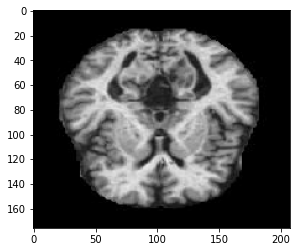

In [ ]:
plt.imshow(img)